# Wolff Algorithm

1) Choose a random site $i$. This is the first member of the cluster

2) Add a link to any nearest neighbour $j$ who has the same spin. The probability of linking is $p = 1 - exp(-2\beta J)$. Any such $j$ which gets linked gets added to the cluster

3) Repeat the process, considering all unlinked nearest neighbours of the cluster

4) The process stops when none of the unlinked neighbours of the cluster get added to the cluster. Flip the spins of all the members of the cluster (remember they will all have the same value).

Lets write the function that implements one step of Wolff cluster update. An important realisation is that the cluster grows via a frontier. One cluster update takes place when the frontier does not change. We keep track of old frontier and calculate the new frontier by querying the neighbours of the old frontier. If no new links are added, that is, when new frontier is an empty set then the process ends.

The array **cluster** stores the indices of sites belonging to the cluster. Both **frontier_new** and **cluster** are appended when a new link is accepted (with probability $p$). The first element of these arrays (cluster and frontier_new/old) contains the number of particles that these arrays contain. 

In [13]:
function wolffstep!(n::Int64,N::Int64,beta::Float64,p::Float64,spin::Array{Int64,1},cluster::Array{Int64,1},frontier_old::Array{Int64,1},frontier_new::Array{Int64,1},neighbour::Array{Int64,1})
    i = rand(1:N)
    cluster[1] = 1
    cluster[2] = i
    frontier_old[1] = 1
    frontier_old[2] = i
    while(frontier_old[1] != 0)
        fill!(frontier_new,zero(Int64))
        for j in 2:(frontier_old[1] + 1)
            fill!(neighbour,zero(Int64))
            x_p = mod(frontier_old[j]-1,n) + 1
            y_p = floor(Int64,(frontier_old[j]-1)/n) + 1
            neighbour[1] = prev(x_p,n) + (n*(y_p-1))
            neighbour[2] = next(x_p,n) + (n*(y_p-1))
            neighbour[3] = x_p + (n*(prev(y_p,n)-1))
            neighbour[4] = x_p + (n*(next(y_p,n)-1))
            for neigh in neighbour
                if(spin[frontier_old[j]] == spin[neigh])
                    if(!(neigh in cluster))
                        if(rand() < p)
                            frontier_new[1] = frontier_new[1] + 1
                            frontier_new[frontier_new[1] + 1] = neigh
                            cluster[1] = cluster[1] + 1
                            cluster[cluster[1] + 1] = neigh
                        end
                    end
                end
            end 
        end
        frontier_old .= frontier_new
    end
    for k in 2:(cluster[1] + 1)
        spin[cluster[k]] = -spin[cluster[k]]
    end
    fill!(cluster,zero(Int64))
    fill!(frontier_old,zero(Int64))
    fill!(frontier_new,zero(Int64))
end

wolffstep! (generic function with 1 method)

We need the following functions as well:

**next,prev** $\rightarrow$ Wrapping around the indices. For example, $(i+1,j)$ might cross the boundary and must be wrapped around to implement PBC

In [11]:
next(i::Int64,n::Int64) = i%n + 1
prev(i::Int64,n::Int64) = (i + n - 2)%n + 1

prev (generic function with 1 method)

**variance** $\rightarrow$ To calculate variance

In [12]:
function variance(x::Array{Float64,1})
    return sum(x.*x)/size(x,1) - (sum(x)/size(x,1))^2
end

variance (generic function with 1 method)

**tcf** $\rightarrow$ Time autocorrelation

In [14]:
function tcf!(timecor::Array{Float64,1},x::Array{Float64,1})
    fill!(timecor,zero(Float64))
    for indx in 1:floor(Int64,size(x,1)/2)+1
        gap = indx - 1
        for timeorigin in 1:size(x,1)-gap
            timecor[indx] = timecor[indx] + x[timeorigin]*x[timeorigin + gap]
        end
        timecor[indx] = timecor[indx]/(size(x,1) - gap)
    end
    avgx = sum(x)/size(x,1)
    timecor .= timecor .- avgx*avgx
    timecor .= timecor./(timecor[1])
end

tcf! (generic function with 1 method)

**keep_positive** $\rightarrow$ Truncate tcf just before it drops below zero, useful when taking log

In [15]:
function keep_positive(x::Array{Float64,1})
    ibreak = 1
    for i in 1:size(x,1)
        if x[i] < 0.2
            ibreak = i
            break
        end
    end
    return x[1:ibreak]
end

keep_positive (generic function with 1 method)

**check_local_energy** $\rightarrow$ Compute the energy contribution of a single site due to its neighbors

In [16]:
function check_local_energy(i::Int64,n::Int64,spin::Array{Int64,1})
    energy=0.0
    p = mod(i-1,n) + 1 
    q = floor(Int64,(i-1)/n) + 1
    energy = spin[next(p,n) + n*(q-1)] + spin[prev(p,n) + n*(q-1)] + spin[p + n*(next(q,n)-1)] + spin[p + n*(prev(q,n)-1)]
    energy = -energy*spin[i]
    return energy
end

check_local_energy (generic function with 1 method)

**calc_tot_eng** $\rightarrow$ Calculate total energy (per site) by adding up the local contributions

In [17]:
function calc_tot_eng(n::Int64,N::Int64,spin::Array{Int64,1})
    toteng = 0.0
    for i in 1:N
        toteng = toteng + check_local_energy(i,n,spin)
    end
    toteng = 0.5*toteng/N
    return toteng
end


calc_tot_eng (generic function with 1 method)

**calc_mag** $\rightarrow$ Calculate per site magnetisation by summing over the grid

In [18]:

function calc_mag(N::Int64,spin::Array{Int64,1})
    mag = 0.0
    for p in 1:N
        mag = mag + spin[p]
    end
    mag = mag/N
    return abs(mag)
end

calc_mag (generic function with 1 method)

**initialize** $\rightarrow$ Initialize all the required arrays.

In [19]:
function initialize(n::Int64)
    N = n*n
    spin = ones(Int64,N)
    cluster = zeros(Int64,N+1)
    frontier_old = zeros(Int64,N+1)
    frontier_new = zeros(Int64,N+1)
    neighbour = zeros(Int64,4)
    return N,spin,cluster,frontier_old,frontier_new,neighbour
end

initialize (generic function with 1 method)

**arraylog** $\rightarrow$ Element-wise log operation on an array

In [20]:
function arraylog(x::Array{Float64,1})
    y = similar(x)
    for i in 1:size(x,1)
        y[i] = log(x[i])
    end
    return y
end

arraylog (generic function with 1 method)

We will now do a preliminary run on $10x10$ lattice, to guage the behaviour of $\tau$ as we change temperature from $2.0$ to $3.0$ in steps of $0.1$. For each value of temperature we average over $10$ realisations.

In [13]:
using Plots
using LsqFit

function prelim(n::Int64,t::Int64,Ti::Float64,Tf::Float64,dT::Float64)
    @. model(x, p) = exp(-x*p[1])
    N,spin,cluster,frontier_old,frontier_new,neighbour = initialize(n)
    tau = zeros(floor(Int64,(Tf-Ti)/dT) + 1)
    step = 1
    for temp in Ti:dT:Tf
        beta = 1/temp
        p = 1.0 - exp(-2*beta)
        magnetisation = zeros(t)
        tot_energy = zeros(t)
        timecor_mag = zeros(floor(Int64,t/2) + 1)
        timecor_eng = zeros(floor(Int64,t/2) + 1)
        timecor_mag_loc = zeros(floor(Int64,t/2) + 1)
        timecor_eng_loc = zeros(floor(Int64,t/2) + 1)
        for m in 1:10
            for i in 1:t
                wolffstep!(n,N,beta,p,spin,cluster,frontier_old,frontier_new,neighbour)
                magnetisation[i] = calc_mag(N,spin)
                tot_energy[i] = calc_tot_eng(n,N,spin)
            end
            
            fill!(timecor_mag_loc,zero(Float64))
            fill!(timecor_eng_loc,zero(Float64))
            
            tcf!(timecor_mag_loc,magnetisation)
            tcf!(timecor_eng_loc,tot_energy)
            
            timecor_eng .= timecor_eng .+ timecor_eng_loc
            timecor_mag .= timecor_mag .+ timecor_mag_loc
        end
        timecor_eng .= timecor_eng./10
        timecor_mag .= timecor_mag./10
        
        ptmag = keep_positive(timecor_mag)
        pteng = keep_positive(timecor_eng)    
        
        fitfunc = zeros(size(pteng,1))
        xdata = 1:size(pteng,1)
        p0 = [1.0]
        fit = curve_fit(model, xdata, pteng, p0)
        sigma = stderror(fit)
        margin_of_error = margin_error(fit, 0.05)
        confidence_inter = confidence_interval(fit, 0.05)
        tau[step] = (1.0/coef(fit)[1])
        step = step + 1
    end
    return tau
end

tau = prelim(10,2000,2.0,3.0,0.1)

11-element Vector{Float64}:
 2.522492452742752
 2.6908084800741205
 3.1482811578101546
 3.516783448948663
 3.6950749805307606
 4.000909969987973
 4.5295133688301705
 4.857756439491747
 5.230148556830908
 5.660614432043163
 6.165170289683963

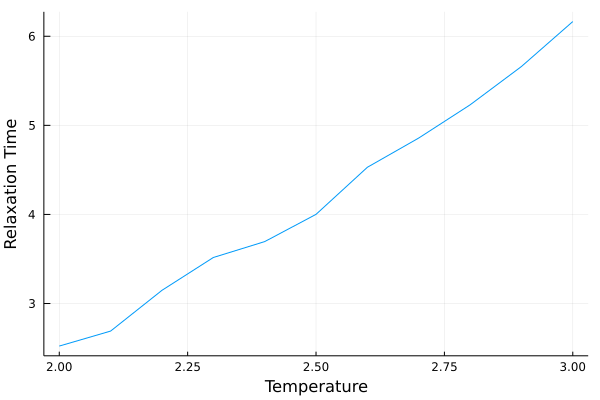

In [14]:
plot(2:0.1:3,tau,xlabel="Temperature",ylabel="Relaxation Time",legend=false)

# Final Production Runs
Now we will do the production runs on $64x64$ lattice with the first $10\tau$ (at least) MC steps being discarded as they form the equilibration run. The next $20\tau$ (at least) MC steps will be used for averaging.

I choose $30$ log distributed temperatures spanning both above and below $T_c$, covering $3$ decades on both sides of $T_c$.

In [22]:
Tc = 2.269
tempset = zeros(30)
for i in 1:15
    tempset[i] = Tc - 10^(-(i-1)*0.2)
end
for j in 1:15
    tempset[j+15] = Tc + 10^(-(15-j)*0.2)
end

The function **main** is the piece of code that will run the core simulation.

In [23]:
function main(n::Int64,teq::Int64,tprod::Int64,tempset::Array{Float64,1},M::Int64)

    
    mag = zeros(size(tempset,1))
    onsager = zeros(size(tempset,1))
    specheat = zeros(size(tempset,1))
    suscep = zeros(size(tempset,1))
    binder = zeros(size(tempset,1))
    Tdist = zeros(size(tempset,1))

    step = 1
    for temp in tempset
        beta = 1/temp
        p = 1.0 - exp(-2*beta)
        magnetisation = zeros(tprod)
        tot_energy = zeros(tprod)
        
   
        ##M Samples per temp
        for m in 1:M
            N,spin,cluster,frontier_old,frontier_new,neighbour = initialize(n)
            
            ##EQUILIBRATION RUN
            for i in 1:teq
                wolffstep!(n,N,beta,p,spin,cluster,frontier_old,frontier_new,neighbour)
            end
        
            ##PRODUCTION RUN
            magnetisation_smp = zeros(Float64,tprod)
            tot_energy_smp = zeros(Float64,tprod)
            for i in 1:tprod
                wolffstep!(n,N,beta,p,spin,cluster,frontier_old,frontier_new,neighbour)
                magnetisation_smp[i] = calc_mag(N,spin)
                tot_energy_smp[i] = calc_tot_eng(n,N,spin)
            end
            magnetisation .= magnetisation .+ magnetisation_smp
            tot_energy .= tot_energy .+ tot_energy_smp
        end
        
        magnetisation .= magnetisation./M
        tot_energy .= tot_energy./M
        
        ##Calculate various propertier wrt temperature
        mag[step] = sum(magnetisation)/tprod
        k = 1.0/(sinh(2.0/temp)*sinh(2.0/temp))
        if(k<1.0)
            onsager[step] = (1 - k^2)^(1.0/8)
        else
            onsager[step] = 0.0
        end
        specheat[step] = beta*beta*variance(tot_energy)
        suscep[step] = beta*variance(magnetisation)
        Tdist[step] = abs(temp - Tc)
        binder[step] = binder_cumulant(magnetisation)
        
        step = step + 1
    end
    return mag,onsager,specheat,suscep,binder,Tdist
end

main (generic function with 1 method)

We choose $64x64$ lattice, $t_{eq} = 100$ and $t_{prod} = 500$. The code below executes the core simulation.

In [26]:
mag64,onsager64,specheat64,suscep64,binder64,Tdist = main(64,100,500,tempset,50)

using DelimitedFiles
open("wolff_64x64","w") do io
	writedlm(io,hcat(mag64,onsager64,specheat64,suscep64,binder64,Tdist))
end

Lets compare the Magnetisation vs Temperature behaviour with the analytical solution provided by Onsager. Note that $J=1$.

\begin{eqnarray}
M &=& (1 - k^2)^{1/8} \\
k &=& \frac{1}{\sinh^2(2\beta)}
\end{eqnarray}

This is only valid when $0 \leq k \leq 1$, which gives us the critical temperature $T_c$ as $k$ becomes negative for for $T>T_c$.


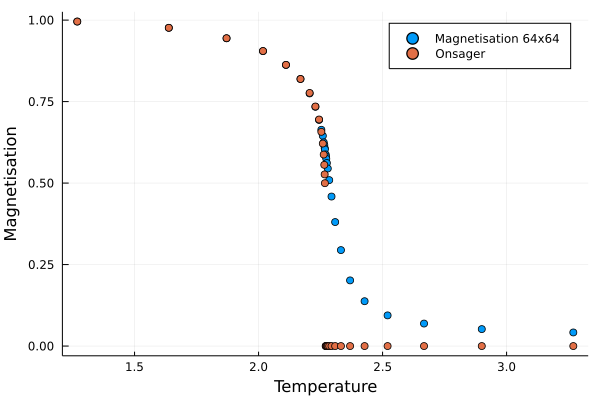

In [29]:
using Plots
scatter(tempset,[mag64,onsager64],xlabel="Temperature",ylabel="Magnetisation",label=["Magnetisation 64x64" "Onsager"])

We clearly see that the order parameter does not drop abruptly to zero beyond $T_c$ but rather shows a gradual drop. This is finite size effect.

### Critical Exponents

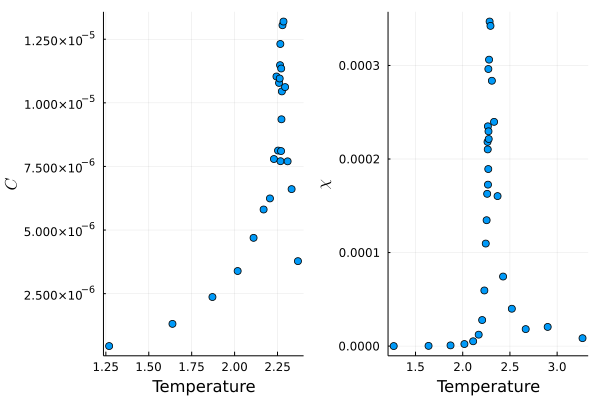

In [49]:
using LaTeXStrings

p1 = scatter(tempset[1:25],specheat64[1:25],xlabel="Temperature",ylabel=L"C",legend=false)
p2 = scatter(tempset,suscep64,xlabel="Temperature",ylabel=L"\chi",legend=false)

plot(p1, p2)# p3, p4,p5, layout = (3,3))

[1.0216561158185407, 0.10038703480564455]
[0.008266063669006264, 0.0034300312031347742]
[2.5459762012630086e-6, -1.5252483690334155]
[5.823076693122985e-7, 0.10519825838985615]
[-2.410656088588261e-6]


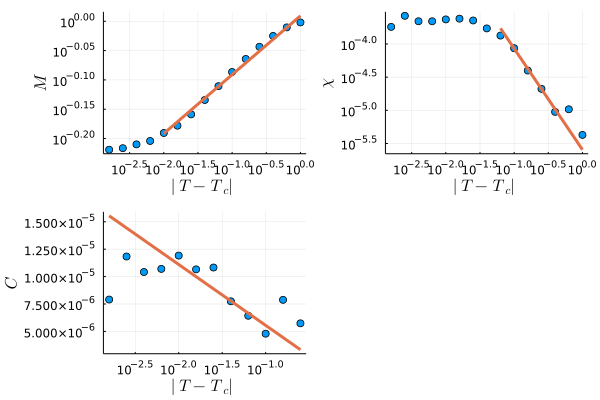

In [42]:
using LsqFit

@. powmodel(x, p) = p[1]*(x^p[2])
@. logmodel(x, p) = p[1]*log(x)


half = floor(Int64,size(tempset,1)/2)

specheat64_half = zeros(half)
suscep64_half = zeros(half)

for i in 1:half
    specheat64_half[i] = 0.5*(specheat64[i] + specheat64[size(tempset,1) + 1 - i])
    suscep64_half[i] = 0.5*(suscep64[i] + suscep64[size(tempset,1) + 1 - i])
end

p0 = [1.0,1.0]
specfit = curve_fit(logmodel, Tdist[1:15],specheat64_half, [-1.0])
susfit = curve_fit(powmodel, Tdist[1:6], suscep64_half[1:6], [-1.0,-1.0])
magfit = curve_fit(powmodel, Tdist[1:11], mag64[1:11], [1.0,1.0])

println(coef(magfit))
println(stderror(magfit))

println(coef(susfit))
println(stderror(susfit))

println(coef(specfit))
#println(stderror(specfit))

p1 = plot(xlabel=L"|T - T_c|", ylabel=L"M",xaxis=:log,yaxis=:log,legend=false)
p1 = plot!(Tdist[1:half], mag64[1:half],seriestype=:scatter)
p1 = plot!(Tdist[1:11], powmodel(Tdist[1:11],coef(magfit)), label="Fit", linewidth=3)

p2 = plot(xlabel=L"|T - T_c|", ylabel=L"\chi",xaxis=:log,yaxis=:log,legend=false)
p2 = plot!(Tdist[1:half], suscep64_half[1:half], seriestype=:scatter)
p2 = plot!(Tdist[1:7], powmodel(Tdist[1:7],coef(susfit)), linewidth=3)

p3 = plot(xlabel=L"|T - T_c|", ylabel=L"C",xaxis=:log,legend=false)
p3 = plot!(Tdist[4:half], specheat64_half[4:half], seriestype=:scatter)
p3 = plot!(Tdist[4:15], logmodel(Tdist[4:15],coef(specfit)), linewidth=3)

plot(p1,p2,p3)

Lets write down the function that gives us the Binder cumulant, defined as 
\begin{equation}
U_4 = 1 - \frac{<m^4>}{3<m^2>^2}
\end{equation}
$m$ being the order parameter.

In [43]:
function binder_cumulant(x::Array{Float64,1})
    bc1 = 0.0
    bc2 = 0.0
    bc = 0.0
    for i in 1:size(x,1)
        bc1 = bc1 + x[i]^4
        bc2 = bc2 + x[i]^2
    end
    bc1 = bc1/size(x,1)
    bc2 = bc2/size(x,1)
    bc = bc1/(bc2*bc2)
    bc = 1 - bc/3.0
    return bc
end

binder_cumulant (generic function with 1 method)

In [50]:
mag5,_,_,suscep5,binder5,_=main(5,100,300,tempset,50)
mag10,_,_,suscep10,binder10,_=main(10,100,300,tempset,50)
mag20,_,_,suscep20,binder20,_=main(20,100,300,tempset,50)
mag40,_,_,suscep40,binder40,_=main(40,100,300,tempset,50)



LoadError: UndefVarError: specheat5 not defined

In [53]:
using DelimitedFiles
open("wolff_64x64","w") do io
	writedlm(io,hcat(mag64,onsager64,specheat64,suscep64,binder64,Tdist))
end
open("wolff_5x5","w") do io
	writedlm(io,hcat(mag5,suscep5,binder5,Tdist))
end
open("wolff_10x10","w") do io
	writedlm(io,hcat(mag10,suscep10,binder10,Tdist))
end
open("wolff_20x20","w") do io
	writedlm(io,hcat(mag20,suscep20,binder20,Tdist))
end
open("wolff_40x40","w") do io
	writedlm(io,hcat(mag40,suscep40,binder40,Tdist))
end

Lets plot the Binder Cumulant with temperature.

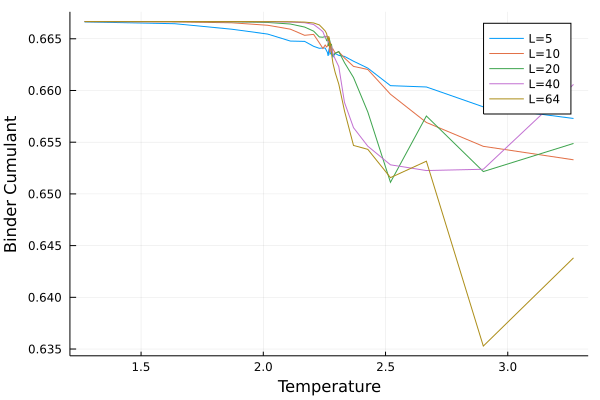

In [54]:
plot(tempset,[binder5,binder10,binder20,binder40,binder64],label=["L=5" "L=10" "L=20" "L=40" "L=64"],xlabel="Temperature",ylabel="Binder Cumulant")

Lets zoom in a little, and switch to semi-log plot as the temperatures were logarithmically distributed around $T_c$.

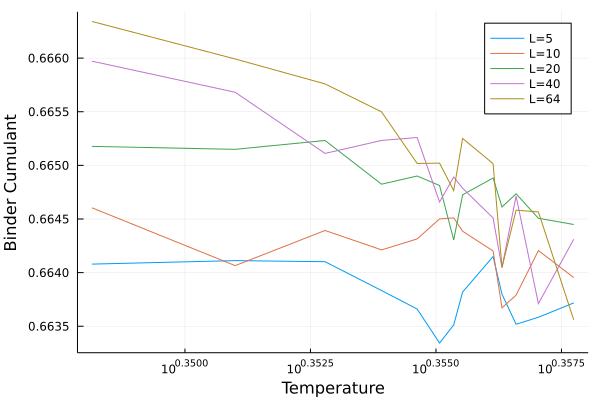

In [55]:
plot(tempset[8:20],[binder5[8:20],binder10[8:20],binder20[8:20],binder40[8:20],binder64[8:20]],label=["L=5" "L=10" "L=20" "L=40" "L=64"],xlabel="Temperature",ylabel="Binder Cumulant",xaxis=:log)

We see that all the size-dependent curves intersect at $T\approx10^{0.355}\approx 2.264$.

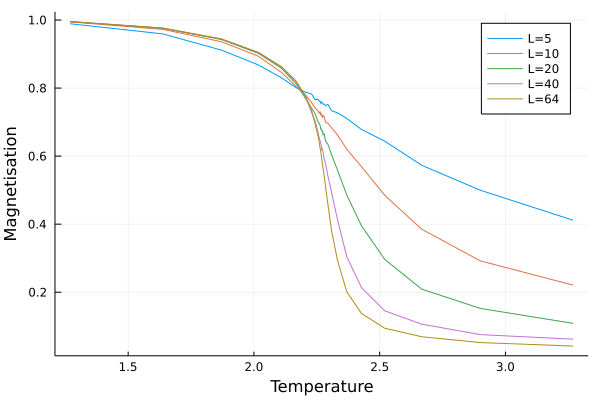

In [56]:
plot(tempset,[mag5,mag10,mag20,mag40,mag64],label=["L=5" "L=10" "L=20" "L=40" "L=64"],xlabel="Temperature",ylabel="Magnetisation")

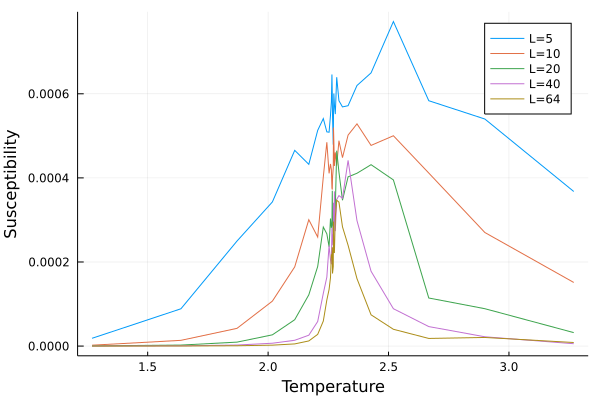

In [57]:
plot(tempset,[suscep5,suscep10,suscep20,suscep40,suscep64],label=["L=5" "L=10" "L=20" "L=40" "L=64"],xlabel="Temperature",ylabel="Susceptibility")